## **Time Series: ARIMA**

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
from google.colab import files
import io
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [ ]:
uploaded = files.upload()

Saving beacon_data.csv to beacon_data.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded["beacon_data.csv"]),sep = ';') #read the .csv file

In [ ]:
data.head()

,id,gtid,vendor_id,subscriber_id,merchant_id,signal_type,entry_date,exit_date,latitude,longitude,dongle_id,distance,proximity,rssi
0,2339839562,F9341167-6D6C-4321-924F-2E6B9D9CEF7A,135,29253903,2133,2,2017-05-01 09:54:14.000000,NaN,40.992124,29.126770,5536,-100.000000,unknown,0.0
1,2340151194,EB93B8DF-1F8D-4BD6-A4E5-67B9BACBF6CF,135,17090954,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
2,2340151210,5563AB7A-C5B0-492D-80E5-04E52A5C0C28,135,17090954,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
3,2340151187,55AFD11A-06A3-4E9D-8735-445F3DE654D7,178,15630196,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
4,2340185826,52DE3BD3-655B-40F2-AC37-1199E0CBD31B,178,15630196,2133,2,2017-05-01 10:32:19.000000,NaN,40.992110,29.126783,5536,1467.799268,far,-85.0


## **Step 1: Check if the columns have NA values**

In [ ]:
for column in data:
    print(column +' '+ str(data[column].isnull().values.any()) +' '+str(sum(data[column].isnull())/len(data)))


id False 0.0
gtid False 0.0
vendor_id False 0.0
subscriber_id False 0.0
merchant_id False 0.0
signal_type False 0.0
entry_date False 0.0
exit_date True 0.8725349301397206
latitude True 0.00775249500998004
longitude True 0.00775249500998004
dongle_id False 0.0
distance True 0.12746506986027945
proximity True 0.12746506986027945
rssi True 0.12746506986027945


### ***Step 1.1: Then I removed some variables***

In [ ]:
data = data.drop("id",axis = 1) # choose variable id or gtid. Both are almost similar.
data = data.drop("merchant_id",axis = 1) # unique ID
data = data.drop("dongle_id",axis = 1) # unique ID
data = data.drop("exit_date",axis = 1) # entry_date = exit_date when signal = 4
data = data.drop("rssi",axis = 1) 


## **Step 2: Removed all the repeated values. Just 4.6% of rows are repeated**

In [ ]:
### 2. Find duplicated values using columns from vendor_id 
# I removed all the repeated values that I found

duplicated_values = data.iloc[:,1:len(data.columns)].duplicated() #there are duplicated values
sum(duplicated_values)/len(duplicated_values) # 4.6% of the rows are duplicated.
data = data[duplicated_values == False] # removed the duplicated rows

In [ ]:
data.head()

,gtid,vendor_id,subscriber_id,signal_type,entry_date,latitude,longitude,distance,proximity
0,F9341167-6D6C-4321-924F-2E6B9D9CEF7A,135,29253903,2,2017-05-01 09:54:14.000000,40.992124,29.126770,-100.000000,unknown
1,EB93B8DF-1F8D-4BD6-A4E5-67B9BACBF6CF,135,17090954,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far
3,55AFD11A-06A3-4E9D-8735-445F3DE654D7,178,15630196,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far
4,52DE3BD3-655B-40F2-AC37-1199E0CBD31B,178,15630196,2,2017-05-01 10:32:19.000000,40.992110,29.126783,1467.799268,far
5,EDDB06CB-686C-4DE5-9662-7798E9FD389A,135,17090954,2,2017-05-01 10:33:24.000000,40.992189,29.126786,1042.299640,far


## **Step 3: Modify dates and removed latitude and longitude**


In [ ]:
data_1 = data[data["proximity"] != "unknown"] #Removed unknown records
data_1 = data_1.drop(["latitude","longitude"],axis = 1)  #Removed latitud and longitude
data_1 = data_1.sort_values(by = ["subscriber_id","entry_date"], ascending = True) #Sort values by subscriber_id and entry_date
data_1["entry_date"] = pd.to_datetime(data_1["entry_date"]) 
data_1["day_entry_date"] = [d.date() for d in data_1["entry_date"]]


In [ ]:
data_1.head()

,gtid,vendor_id,subscriber_id,signal_type,entry_date,distance,proximity,day_entry_date
80318,63C75856-B672-4175-9CAA-EF1A26A06814,6,26992,2,2017-07-29 15:51:08,1807.501630,far,2017-07-29
80836,91A411BF-6FE5-4E41-ACDC-85D1825D197A,6,26992,2,2017-07-29 15:51:48,2017.969873,far,2017-07-29
83933,E3BE7BF7-2583-48E1-A5B8-9013F77FE63E,6,26992,2,2017-07-29 15:54:46,681.292069,far,2017-07-29
80322,22D56BAA-AEB2-4796-8B2D-AEB44CF83CF8,6,26992,2,2017-07-29 15:58:09,1527.666797,far,2017-07-29
83935,8091EAB2-FEB7-4F31-9A66-359EBB992049,6,26992,2,2017-07-29 16:00:01,1573.744946,far,2017-07-29


## **Step 4: Customer per day and sales per day**
In this stage, the number of unique clients per day was calculated.

In [ ]:
data_customers_per_day = data_1.groupby(["day_entry_date"]).agg({"subscriber_id":pd.Series.nunique}).rename(columns = {"subscriber_id":"subscriber_unique"}).reset_index() #Count the unique number of customers per day


Then, the sales per day were calculated

In [ ]:
sales_per_day = data_1[data_1["proximity"].isin(["immediate","near"])] #Considering "immediate" and "near" signals
sales_per_day = sales_per_day.groupby(["day_entry_date"]).agg({"subscriber_id":pd.Series.nunique}).rename(columns = {"subscriber_id":"subscriber_unique"}).reset_index()


Finally, the two data sets are joined.



No handles with labels found to put in legend.


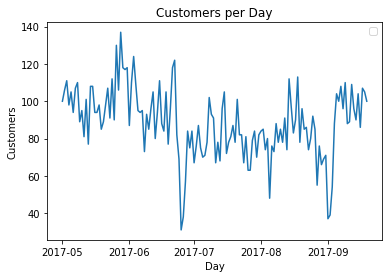

No handles with labels found to put in legend.


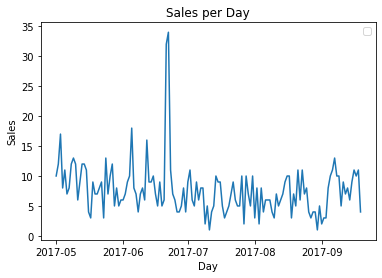

In [ ]:
final_df = pd.merge(data_customers_per_day,sales_per_day, how = "left", on = ["day_entry_date"])

plt.plot(final_df.day_entry_date, final_df.subscriber_unique_x)
plt.xlabel('Day')
plt.ylabel('Customers')
plt.title('Customers per Day')
plt.legend()
plt.show()     

plt.plot(final_df.day_entry_date, final_df.subscriber_unique_y)
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales per Day')
plt.legend()
plt.show()     

## **Step 5: Analysis of the time series**

In [ ]:
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))
        

print(check_stationarity(final_df.subscriber_unique_x))
print(check_stationarity(final_df.subscriber_unique_y))



The test statistic: -4.368623
p-value: 0.000337
Critical Values:
1%: -3.478
5%: -2.882
10%: -2.578
None
The test statistic: -7.617544
p-value: 0.000000
Critical Values:
1%: -3.478
5%: -2.882
10%: -2.578
None


In both cases the p-value is less than 5% so I can reject the null hypothesis.
With this, the time series seems to be stationary. In this model, the number of customers will be used to predict sales.

In [ ]:

#change press to another column to train model for different column

print(sm.tsa.stattools.adfuller(final_df['subscriber_unique_x']))
print(sm.tsa.stattools.adfuller(final_df['subscriber_unique_y']))

#Now it is necessary to obtain difference between each row.
final_df['lag']=final_df['subscriber_unique_x'].shift()

final_df.dropna(inplace=True) # Removed null values

#Train arima the ARIMA Model (1,0,1) (First Model)
model3=sm.tsa.ARIMA(endog=final_df['subscriber_unique_y'],exog=final_df[['lag']],order=[1,0,1]) 
results3=model3.fit() # Get the results

# MSE and RMSE using residuals
mse = (np.square(results3.resid).sum())/len(results3.resid)
rmse = np.sqrt(mse)

def arima_models(df,p,d,q): #This function allows evaluating different models through different orders for the variables p, q, d
    results_arima = []
    for p in range(0,p+1):
        for q in range(0,q+1):
            df.subscriber_unique_y = df.subscriber_unique_y.astype('float32')
            model3=sm.tsa.ARIMA(endog=df['subscriber_unique_y'],exog=df[['lag']],order=[p,d,q])
            result_model=model3.fit()
            mse = (np.square(result_model.resid).sum())/len(result_model.resid)
            rmse = np.sqrt(mse)
            results_arima.append([p,q,mse,rmse])
            df_results_arima = pd.DataFrame(results_arima, columns = ['p','q','mse','rmse'])
    print(df_results_arima);
            
        
arima_models(final_df,2,0,2)

(-4.416361588121319, 0.00027765502068054584, 1, 139, {'1%': -3.4782936965183815, '5%': -2.882567574015525, '10%': -2.5779830117488745}, 1044.9135983199017)
(-7.639964551179322, 1.9074839696389596e-11, 0, 140, {'1%': -3.4779446621720114, '5%': -2.8824156122448983, '10%': -2.577901887755102}, 713.1626978348012)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was pro

   p  q        mse      rmse
0  0  0  16.863058  4.106465
1  0  1  15.494095  3.936254
2  0  2  15.369750  3.920427
3  1  0  15.414587  3.926142
4  1  1  15.399749  3.924251
5  1  2  15.361465  3.919370
6  2  0  15.393481  3.923453
7  2  1  15.108049  3.886907
8  2  2  15.360647  3.919266


Of all the models evaluated, the best results were obtained with the ARIMA(2,0,1) which obtained a mse = 15.109 and rmse = 3.886